# Proximal gradient algorithm
This first tutorial details how to use a proximal gradient algorithm
to solve the LASSO problem:
$$
\min_u \;f(u) =  \frac{1}{2}\| A u - b \|_2^2 + \lambda \|u \|_1
$$
with $A$ given matrix, and $b$ vector of observation.
As the function $f$ is non-smooth and additive, the resolution of the LASSO
problem is a good use case for the proximal gradient algorithm.

## Table of contents <a name="toc"></a>

1. [Settings](#settings)
2. [Proximal gradient algorithm](#prox)
3. [Accelerated proximal gradient](#acc_prox)
4. [Final results on simulated data](#simulated)
    1. [First results](#res_sim)
    2. [Influence of the regularization](#reg_sim)
    3. [Impact of the normalization](#norm_sim)
5. [Final results on real data](#real)
    1. [First results](#res_real)
    2. [Influence of the regularization](#reg_real)
    3. [Impact of the normalization](#norm_real)


## Settings <a name="settings"></a>
We import the usual packages:

In [1]:
using Printf, Random
using LinearAlgebra
using JuMP

Fix seed

In [2]:
Random.seed!(2713);

We first generate artificial data to study the algorithm:

In [3]:
include("data.jl")

nVariables = 50;
nCassures = 50;
xMin, xMax = build_bounds(nVariables)
A = build_X(nVariables, nCassures, xMin, xMax);
b = randn(nCassures)
λ = 50.0;

Build oracle for objective:

In [4]:
f(u) = 0.5 * norm(A*u - b, 2)^2 + λ * norm(u, 1);

and we add a function to evaluate the prox operator of the $\ell_1$-norm:

In [5]:
function prox_g(v, u, ε, λ)
    step = ε * λ
    for i in 1:length(u)
        if u[i] >= 0
            v[i] = max(u[i]-step,0)
        else
            v[i] = min(u[i]+step,0)
        end
    end
    return v
end;

Get optimal solution with a QP solver

In [6]:
using OSQP
# using CPLEX

function get_solution(A, b, λ)
    n, m = size(A)
    model = Model(with_optimizer(OSQP.Optimizer))
    JuMP.set_silent(model)
    # Variable u
    @variable(model, u[1:m])
    # Variable t, linearizing the \|.\|_1 term
    @variable(model, t[1:m])
    @constraint(model, t .>= u)
    @constraint(model, t .>= -u)
    @objective(model, Min, 0.5 * dot(A*u - b, A*u - b) + λ * sum(t))
    JuMP.optimize!(model)
    return JuMP.objective_value(model)
end
optsol = get_solution(A, b, λ)
println("Optimal solution is equal to ", optsol)

Optimal solution is equal to 12.090246585596102


_Back to [table of contents](#toc)._

## Proximal gradient algorithm <a name="prox"></a>
At iteration $k$ and iterate $u_k$, the proximal gradient algorithm computes
$$
\begin{aligned}
& v_k = u_k - \varepsilon_k \nabla F(u_k) \\
& u_{k+1} = \text{prox}_{\varepsilon_k g}(v_k)
\end{aligned}
$$

In [7]:
function proximal_gradient(A, b, u0, ε, λ; maxit=1000)
    # iterate
    u = copy(u0)
    # intermediate vector
    v = similar(u0)
    # instantiate array to store trace
    trace_f = Float64[]
    push!(trace_f, f(u))

    for nit in 1:maxit
        u = prox_g(v, u - ε*(transpose(A)*A*u-transpose(A)*b), ε, λ)
        # TODO: code proximal gradient algorithm here
        # evaluate objective at current point
        f_k = f(u)
        #TODO
        push!(trace_f, f_k)
    end
    return trace_f
end

proximal_gradient (generic function with 1 method)

We know that the optimal step is given by the inverse of the Lipschitz
coefficient $L$ of the gradient of $F$, the smooth part of the objective.
As $F(u) = 0.5 \|A u - b \|_2^2$, we get

In [8]:
L = eigmax(A' * A)
step = 1 / L

3.663415689163745e-6

We choose as initial point the vector $u_0 = 0$.

In [9]:
u0 = zeros(nVariables) ;

_Back to [table of contents](#toc)._

## Accelerated proximal gradient <a name="acc_prox"></a>
The accelerated proximal gradient algorithm is a variant of the proximal
gradient algorithm, which is known for its better performance.

At iteration $k$ and iterate $u_k$, the accelerated proximal gradient
algorithm computes
$$
\begin{aligned}
& w_k = u_k - \varepsilon_k \nabla F(u_k) \\
& v_{k+1} = \text{prox}_{\varepsilon_k g}(w_k) \\
& u_{k+1} = v_{k+1} + \dfrac{k - 1}{k+2} (v_{k+1} - v_k)
\end{aligned}
$$

In [10]:
function accelerated_proximal_gradient(A, b, u0, ε, λ; maxit=1000)
    # intermediate vector
    u = copy(u0)
    v_next = copy(u0)
    v_prev = copy(u0)
    w = similar(u0)
    trace_f = Float64[]
    push!(trace_f, f(u))

    for nit in 1:maxit
        v_next = prox_g(v_next, u - ε*(transpose(A)*A*u-transpose(A)*b), ε, λ)
        u = v_next + (v_next-v_prev)*(nit-1)/(nit+2)
        f_k = f(u)
        # TODO: code accelerated proximal gradient here
        push!(trace_f, f_k)
        copy!(v_prev, v_next)
    end
    return trace_f
end

accelerated_proximal_gradient (generic function with 1 method)

_Back to [table of contents](#toc)._

## Final results on simulated data <a name="simulated"></a>

### First results <a name="res_sim"></a>

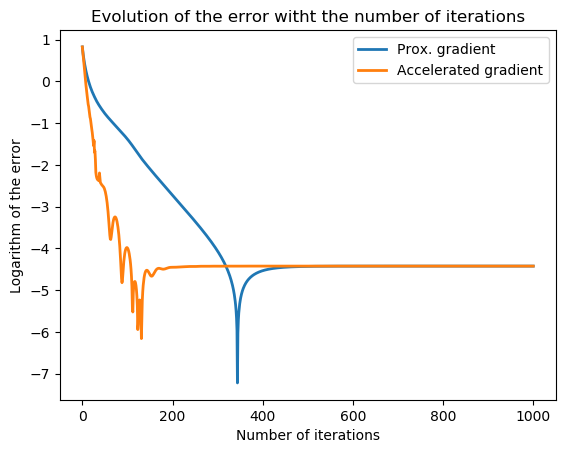

PyObject <matplotlib.legend.Legend object at 0x15af7f310>

In [11]:
using PyPlot
trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=1000)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=1000)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Logarithm of the error")
title("Evolution of the error witht the number of iterations")
legend()

We observe that the accelerated gradient error decreases faster, as expected. 

We also note some peak on the error of the standard proximal gradient algorithm: this is surely due to the fact that we take the logarithm of the error, and thus have to compute the absolute value of the error.

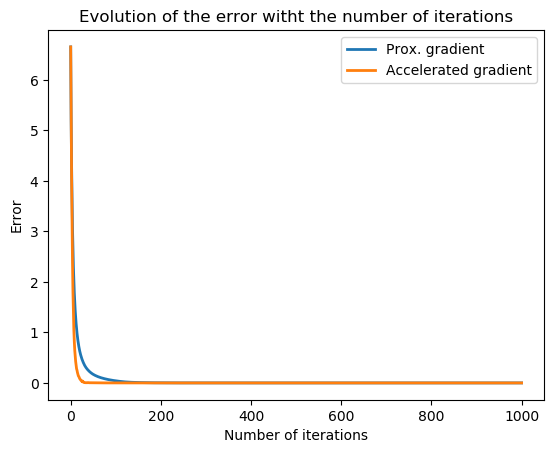

PyObject <matplotlib.legend.Legend object at 0x161b45310>

In [12]:
plot(trace_1 .- optsol, lw=2., label="Prox. gradient")
plot(trace_2 .- optsol, lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Error")
title("Evolution of the error witht the number of iterations")
legend()

In [18]:
(trace_1 .- optsol)[330:350]

21-element Array{Float64,1}:
  1.8831409397179755e-5
  1.732906418894231e-5 
  1.5866887991933254e-5
  1.4443800552044195e-5
  1.3058750875316605e-5
  1.1710716423252165e-5
  1.039870233654483e-5 
  9.121740678352808e-6 
  7.878889704215908e-6 
  6.669233144407372e-6 
  5.49187950404928e-6  
  4.3459613916496664e-6
  3.2306348636268467e-6
  2.1450787794918824e-6
  1.0884941907818302e-6
  6.010372288756116e-8 
 -9.408490022622118e-7 
 -1.915099943516907e-6 
 -2.8633651858456233e-6
 -3.786341501665902e-6 
 -4.6847068535527114e-6

This plot confirms the previous interpretation.

_Back to [table of contents](#toc)._

### Influence of the regularization <a name="reg_sim"></a>

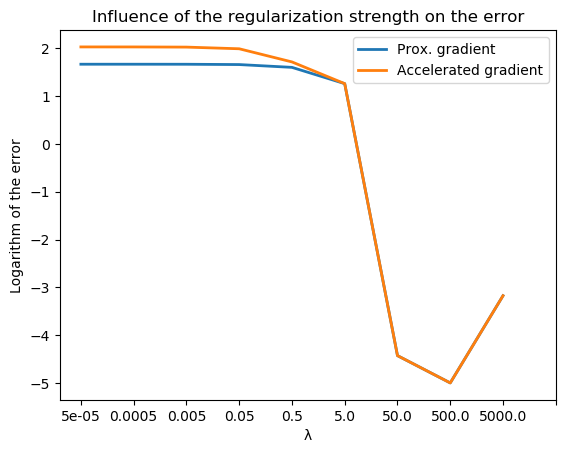

PyObject <matplotlib.legend.Legend object at 0x161ca7550>

In [19]:
e_min = -5 ;
e_max = 3 ;
lambdas = [5*(float(10)^(i)) for i in range(e_min,e_max, step=1)]

trace_prox = Float64[]
trace_prox_acc = Float64[]

for λ in lambdas

    optsol = get_solution(A, b, λ)
    
    trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox, trace_1[length(trace_1)] - optsol)
    trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox_acc, trace_2[length(trace_2)] - optsol)
    
end

plot(log10.(abs.(trace_prox)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_prox_acc)), lw=2., label="Accelerated gradient")
xticks(range(0,length(lambdas),step=1),lambdas)
xlabel("λ")
ylabel("Logarithm of the error")
title("Influence of the regularization strength on the error")
legend()

We observe that if the regularization is too small, the algorithms fails to find the solution. When the strength of the regularization is higher, they perform better but we should not increase too much this parameter since the performances decline then. Indeed, too much regularization will lead to an unwanted sparse solution, since the $\ell_1$-norm term will dominate the initial regression problem.

_Back to [table of contents](#toc)._

### Impact of the normalization <a name="norm_sim"></a>

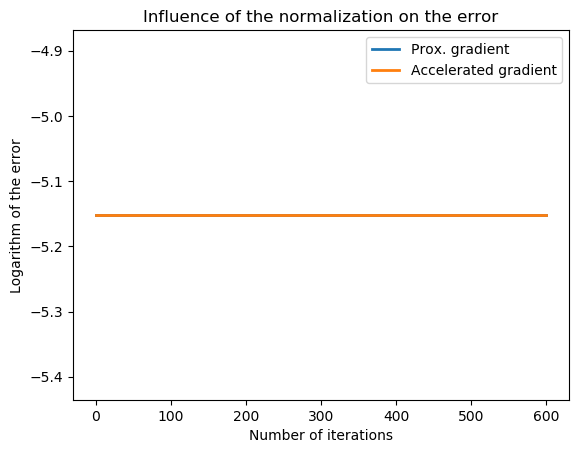

PyObject <matplotlib.legend.Legend object at 0x1642aaa90>

In [21]:
using Statistics

A = (A.-mean(A, dims=1))./std(A, dims=1)

λ = 50.0;
u0 = zeros(size(A,2));

L = eigmax(A' * A)
step = 1 / L

optsol = get_solution(A, b, λ)

trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=600)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=600)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Logarithm of the error")
title("Influence of the normalization on the error")
legend()

We notice here that when normalizing our data, both algorithms converge in one iteration. It is very impressive, even if we expected better performance. Indeed, the explanatory variables contained in $A$ have different meanings and thus scales, and we should rescale them in a coherent scale in order to compare things that are truly comparable.

_Back to [table of contents](#toc)._

## Final results on real data <a name="real"></a>

### First results <a name="res_real"></a>

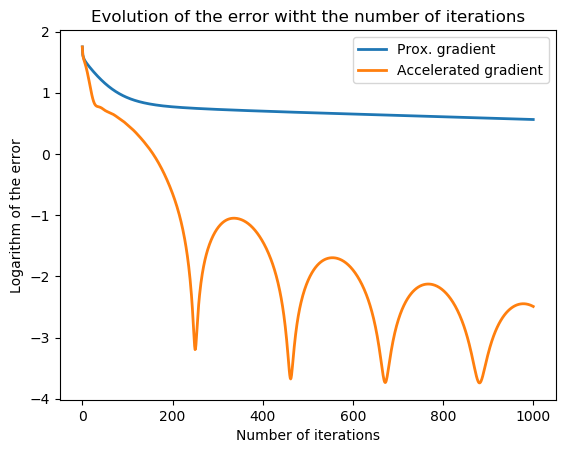

PyObject <matplotlib.legend.Legend object at 0x14b12b690>

In [22]:
include("libsvm_parser.jl")
data = parse_libsvm("diabetes")

A = to_dense(data);
b = data.labels;
λ = 50.0;
u0 = zeros(size(A,2));

L = eigmax(A' * A)
step = 1 / L

optsol = get_solution(A, b, λ)

trace_1 = proximal_gradient(A, b, u0, step, λ)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Logarithm of the error")
title("Evolution of the error witht the number of iterations")
legend()

Again, the accelerated proximal gradient error decreases faster.

As observed (but not commented) with the simulated data, the evolution of the accelerated proximal gradient error with the number of iterations has an interesting shape. This is typical of this algorithm: step $t+1$ depends not only on the proximal function at step $t+1$ but also at step $t$. This makes the algorithm swing aroung the optimal solution. 

We also have the impression that the proximal gradient algorithm does not converge. To investigate further, we increase the number of iterations.

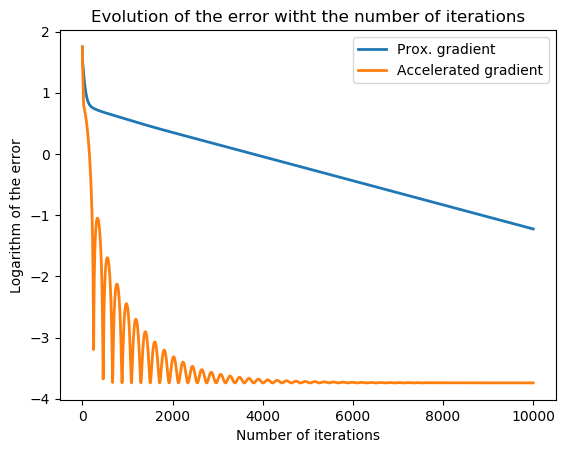

PyObject <matplotlib.legend.Legend object at 0x164536550>

In [23]:
trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=10000)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=10000)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Logarithm of the error")
title("Evolution of the error witht the number of iterations")
legend()

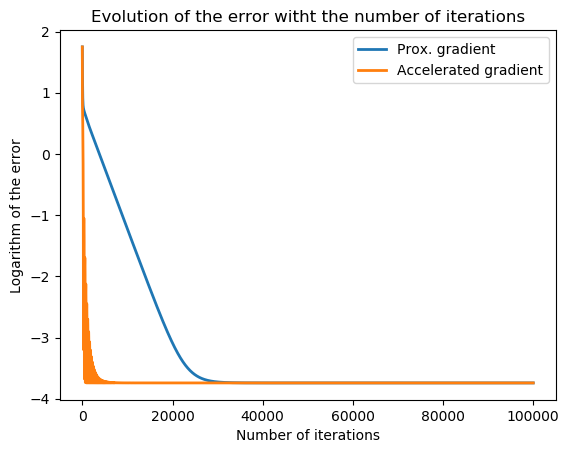

PyObject <matplotlib.legend.Legend object at 0x16478a410>

In [24]:
trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=100000)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=100000)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Logarithm of the error")
title("Evolution of the error witht the number of iterations")
legend()

Here the difference of speed between the two algorithms is really evident. And we can confirm that the proximal gradient algorithm converges. 

_Back to [table of contents](#toc)._

### Influence of the regularization <a name="reg_real"></a>

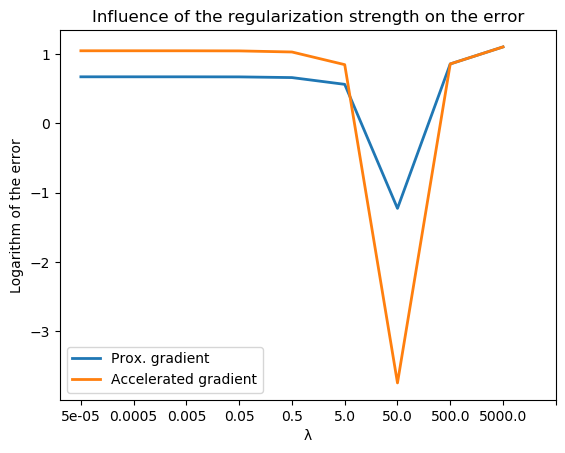

PyObject <matplotlib.legend.Legend object at 0x1640b0390>

In [25]:
e_min = -5 ;
e_max = 3 ;
lambdas = [5*(float(10)^(i)) for i in range(e_min,e_max, step=1)]

trace_prox = Float64[]
trace_prox_acc = Float64[]

for λ in lambdas

    optsol = get_solution(A, b, λ)
    
    trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox, trace_1[length(trace_1)] - optsol)
    trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox_acc, trace_2[length(trace_2)] - optsol)
    
end

plot(log10.(abs.(trace_prox)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_prox_acc)), lw=2., label="Accelerated gradient")
xticks(range(0,length(lambdas),step=1),lambdas)
xlabel("λ")
ylabel("Logarithm of the error")
title("Influence of the regularization strength on the error")
legend()

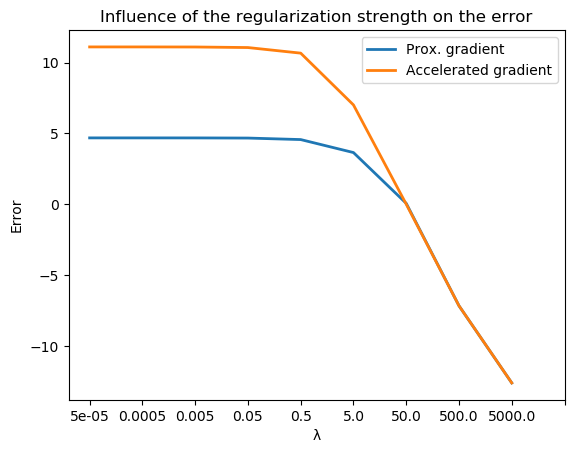

PyObject <matplotlib.legend.Legend object at 0x165ff6f10>

In [26]:
plot(trace_prox, lw=2., label="Prox. gradient")
plot(trace_prox_acc, lw=2., label="Accelerated gradient")
xticks(range(0,length(lambdas),step=1),lambdas)
xlabel("λ")
ylabel("Error")
title("Influence of the regularization strength on the error")
legend()

We observe the same phenomenon as with the simulated data, but here there seems to be a very small range of regularization values that allows the algorithms to fully converge.

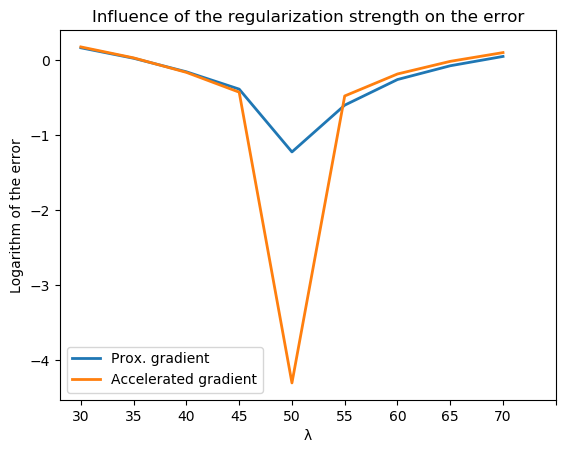

PyObject <matplotlib.legend.Legend object at 0x1664e8190>

In [27]:
lambdas = range(30, 70, step=5)

trace_prox = Float64[]
trace_prox_acc = Float64[]

for λ in lambdas

    optsol = get_solution(A, b, λ)
    
    trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox, trace_1[length(trace_1)] - optsol)
    trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=10000)
    push!(trace_prox_acc, trace_2[length(trace_2)] - optsol)
    
end

plot(log10.(abs.(trace_prox)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_prox_acc)), lw=2., label="Accelerated gradient")
xticks(range(0,length(lambdas),step=1),lambdas)
xlabel("λ")
ylabel("Logarithm of the error")
title("Influence of the regularization strength on the error")
legend()

_Back to [table of contents](#toc)._

### Impact of the normalization <a name="norm_real"></a>

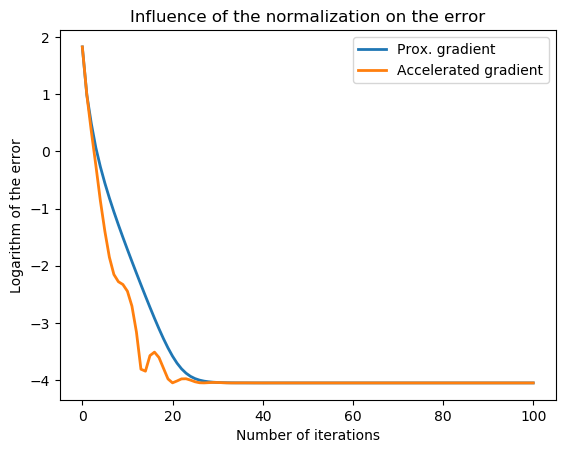

PyObject <matplotlib.legend.Legend object at 0x16655d890>

In [28]:
A = (A.-mean(A, dims=1))./std(A, dims=1)

λ = 50.0;
u0 = zeros(size(A,2));

L = eigmax(A' * A)
step = 1 / L

optsol = get_solution(A, b, λ)

trace_1 = proximal_gradient(A, b, u0, step, λ, maxit=100)
trace_2 = accelerated_proximal_gradient(A, b, u0, step, λ, maxit=100)

plot(log10.(abs.(trace_1 .- optsol)), lw=2., label="Prox. gradient")
plot(log10.(abs.(trace_2 .- optsol)), lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Logarithm of the error")
title("Influence of the normalization on the error")
legend()

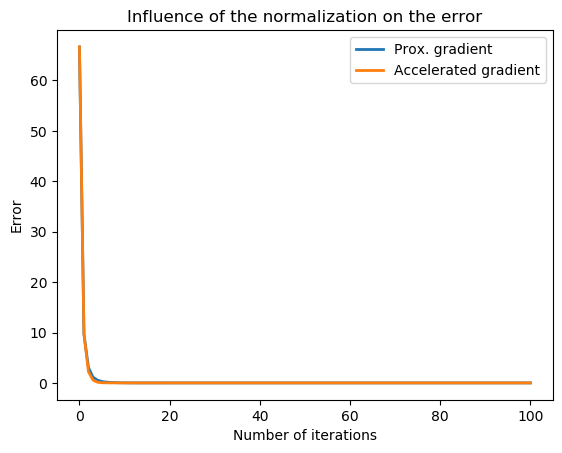

PyObject <matplotlib.legend.Legend object at 0x1666cf710>

In [29]:
plot(trace_1 .- optsol, lw=2., label="Prox. gradient")
plot(trace_2 .- optsol, lw=2., label="Accelerated gradient")
xlabel("Number of iterations")
ylabel("Error")
title("Influence of the normalization on the error")
legend()

Again, the normalization has a very good impact of the performance of both algorithms, even though with the real data more than one pass is needed, it is still a notable improvement. 

_Back to [table of contents](#toc)._